# Recommender ChatBot: Update Users and Items embeddings using DeepFM model

Generate users/items embeddings using DeepFM collaborative filtering model Then store embeddings into a chromadb database.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
BASE_PATH    = '../..'
LIB_PATH     = f'{BASE_PATH}/lib'
API_PATH     = f'{BASE_PATH}/chat-bot-api'

In [3]:
import sys
sys.path.append(LIB_PATH)
sys.path.append(API_PATH)


import torch
import pytorch_common
import pytorch_common.util as pu
import util as ut
import os

## Setup

In [4]:
pu.LoggerBuilder().on_console().build()

<RootLogger root (INFO)>

In [5]:
import pytorch_common
pytorch_common.__version__

'0.3.8'

In [6]:
torch.__version__

'2.1.2+cu118'

In [7]:
pu.set_device_name('gpu')

pu.get_device(), torch.cuda.is_available()

(device(type='cuda', index=0), True)

In [8]:
ut.set_seed(42)

In [9]:
os.environ['TMP_PATH']         = f'{BASE_PATH}/tmp'
os.environ['DATASET_PATH']     = f'{BASE_PATH}/datasets'
os.environ['WEIGHTS_PATH']     = f'{BASE_PATH}/weights'
os.environ['METRICS_PATH']     = f'{BASE_PATH}/metrics'
os.environ['MONGODB_URL']      = 'mongodb://0.0.0.0:27017'
os.environ['MONGODB_DATABASE'] = 'chatbot'
os.environ['CHROMA_HOST']      = '0.0.0.0'
os.environ['CHROMA_PORT']      = '9090'


from app_context import AppContext

2024-01-31 21:13:15.813796: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-31 21:13:16.295927: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-01-31 21:13:16.556126: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-31 21:13:16.566951: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GP

<Figure size 640x480 with 0 Axes>

## Run Job

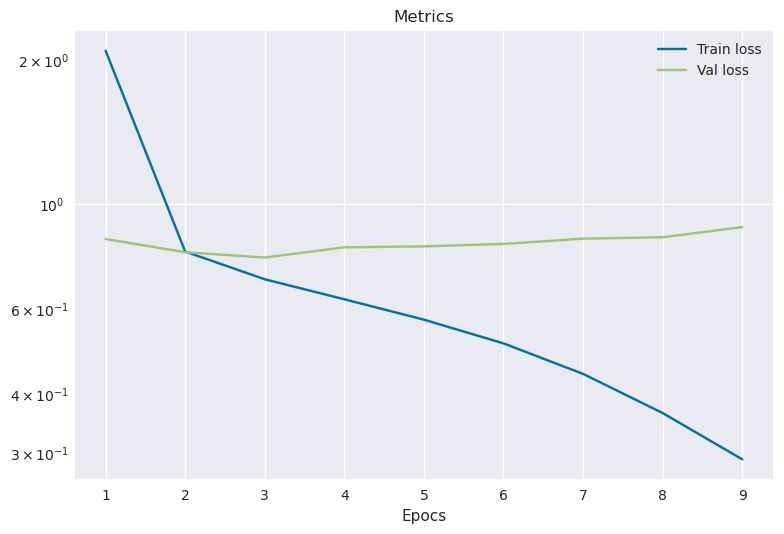

2024-01-31 21:14:49,753 - INFO - {'time': '0:00:08.49', 'epoch': 10, 'train_loss': 0.2283047422386852, 'val_loss': 0.8911736011505127, 'lr': 0.001}


Processing:   0%|          | 0/250 [00:00<?, ?it/s]

Ordered by mAP@5(4,5):


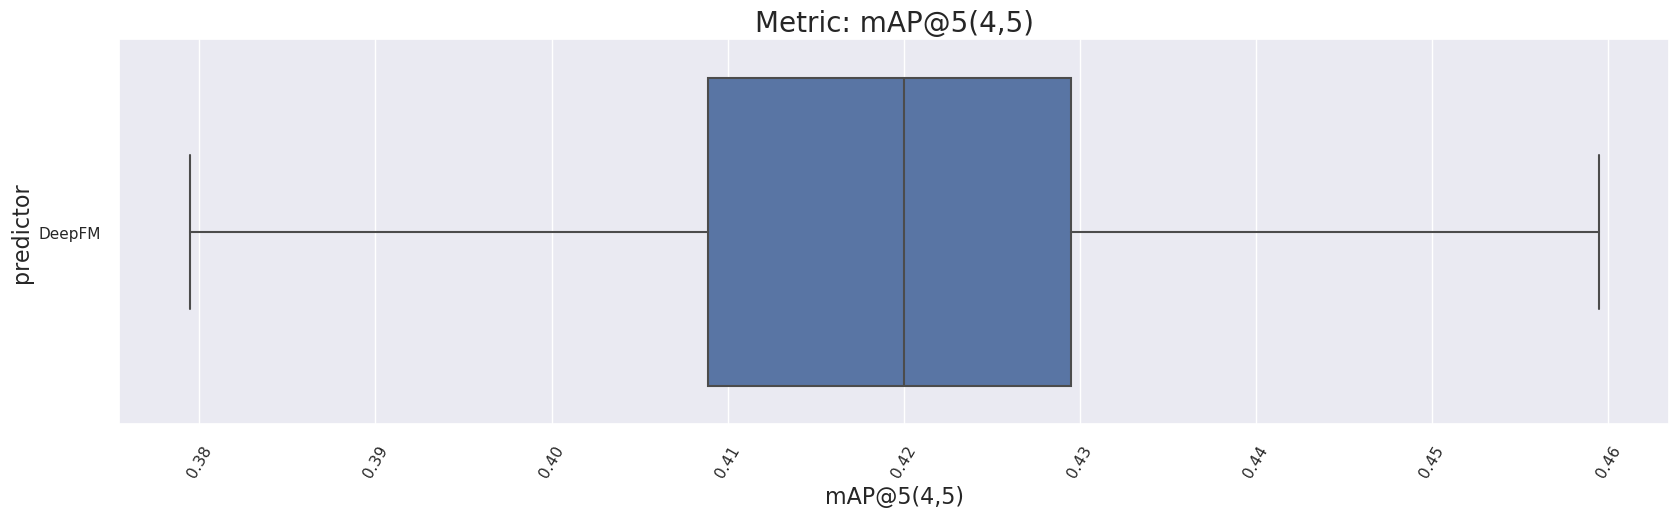

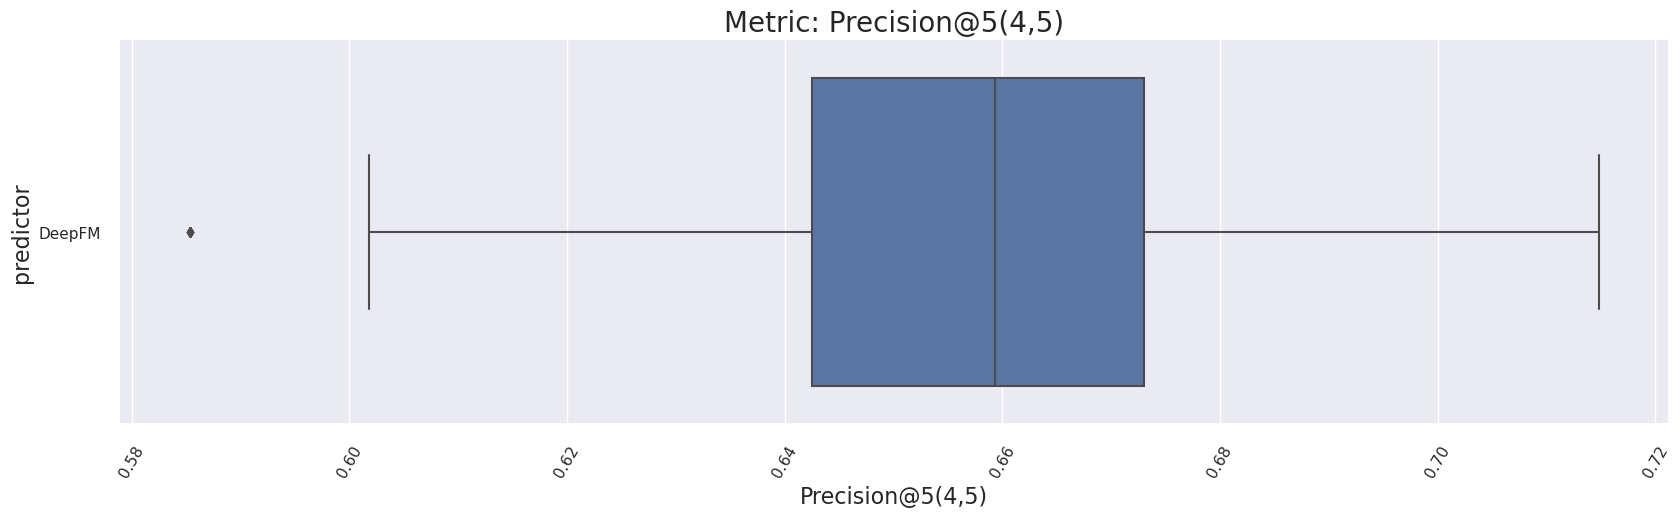

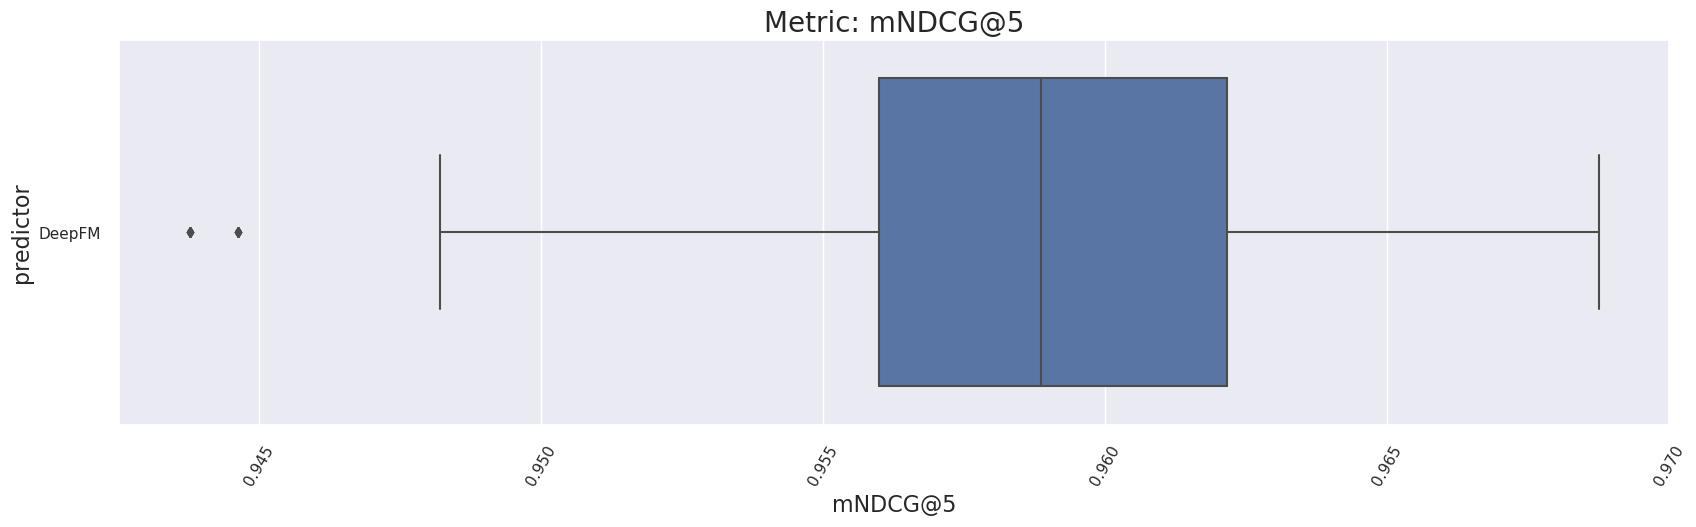

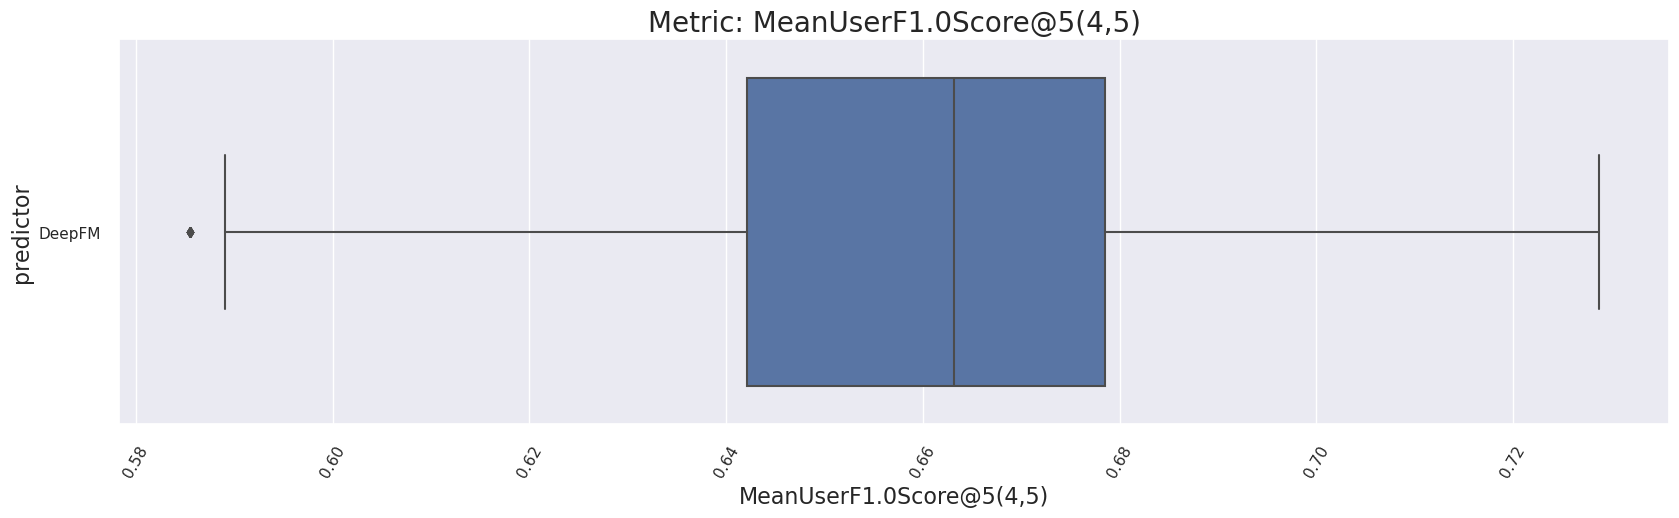

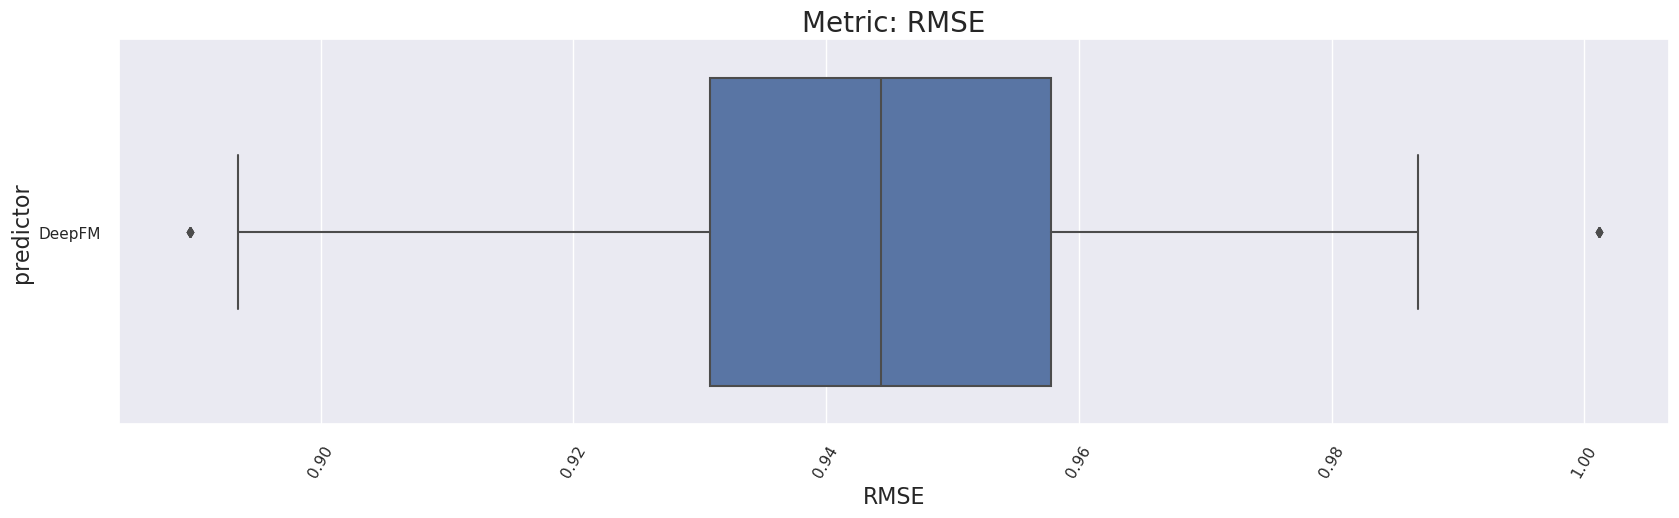

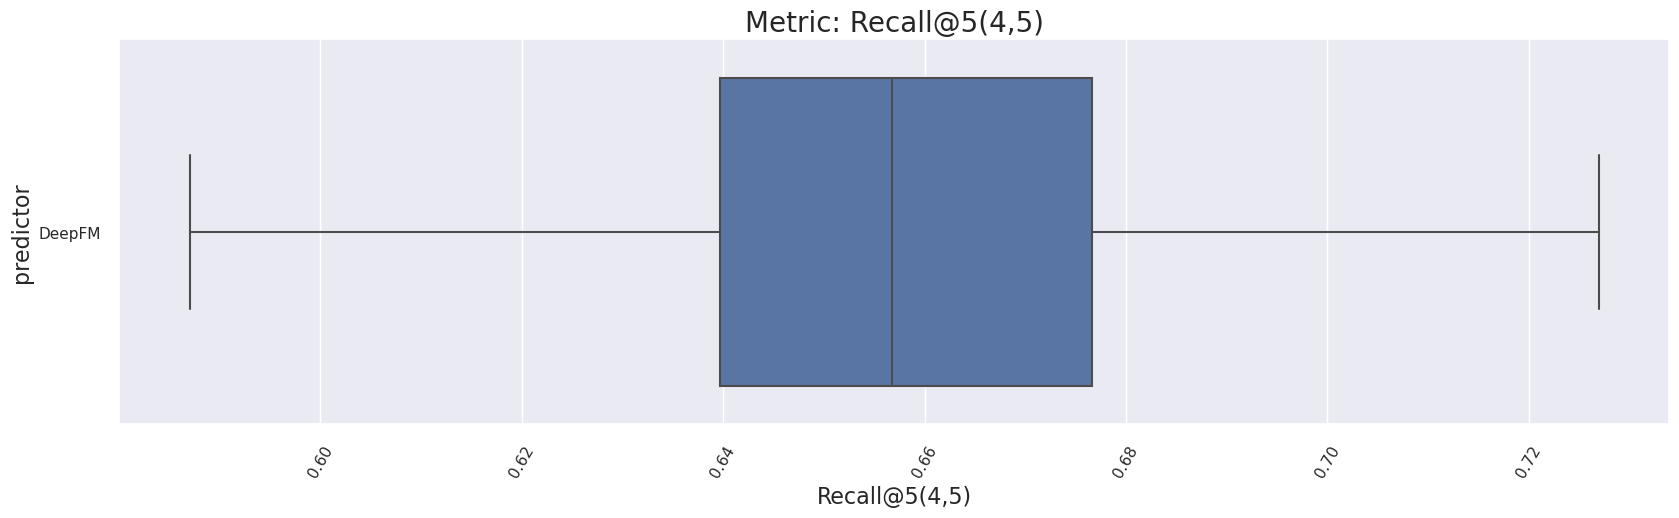

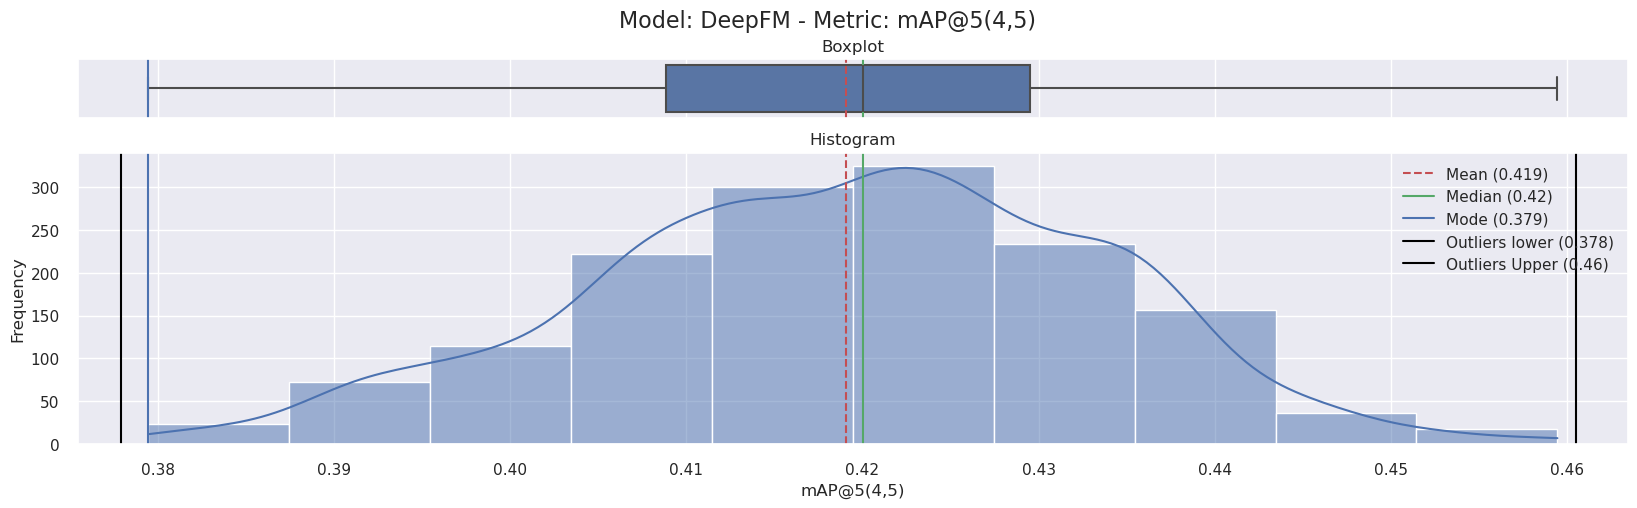

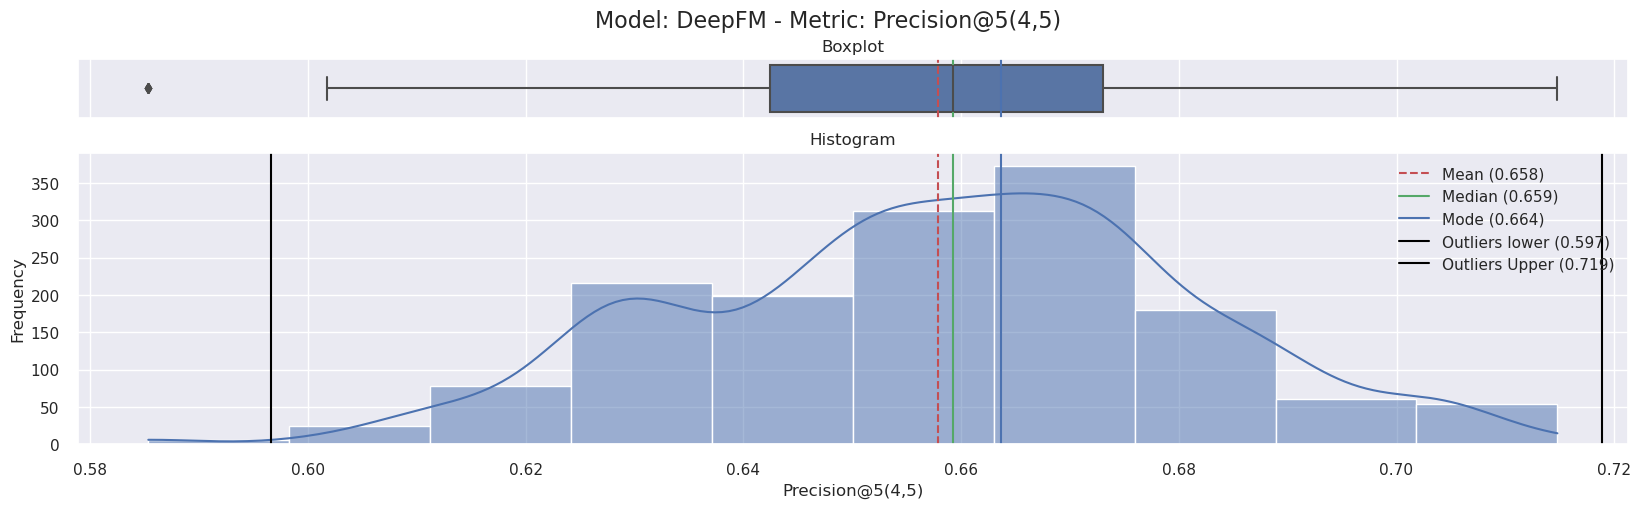

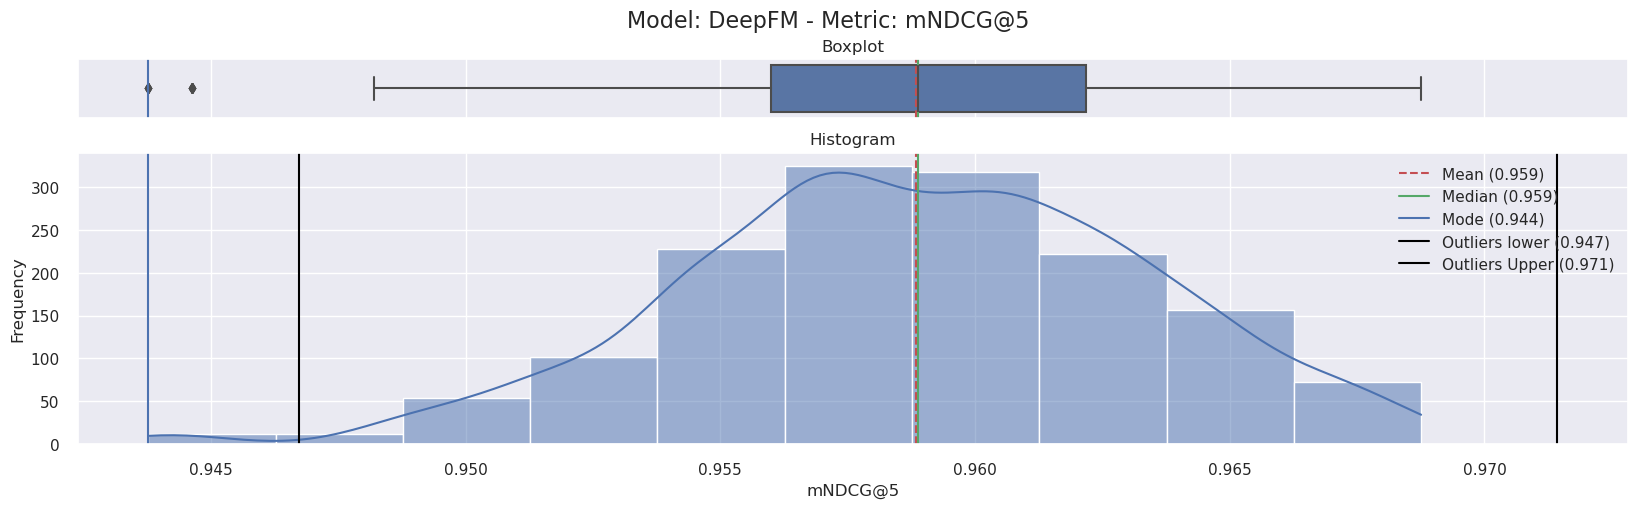

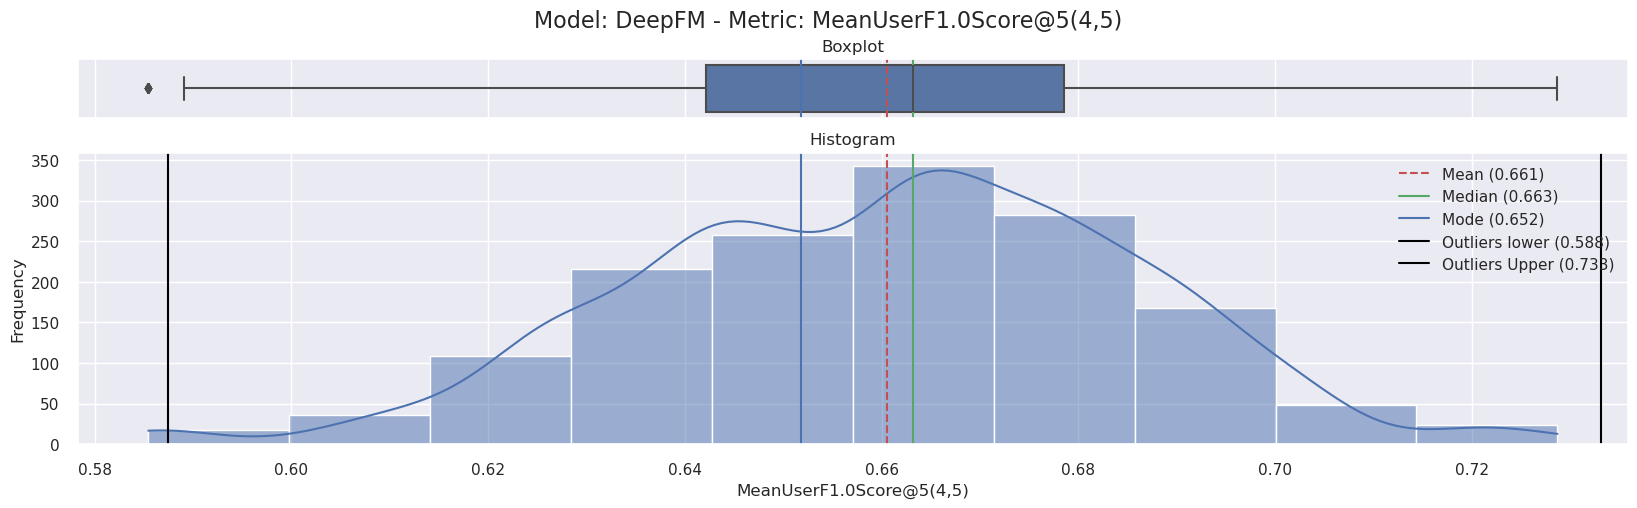

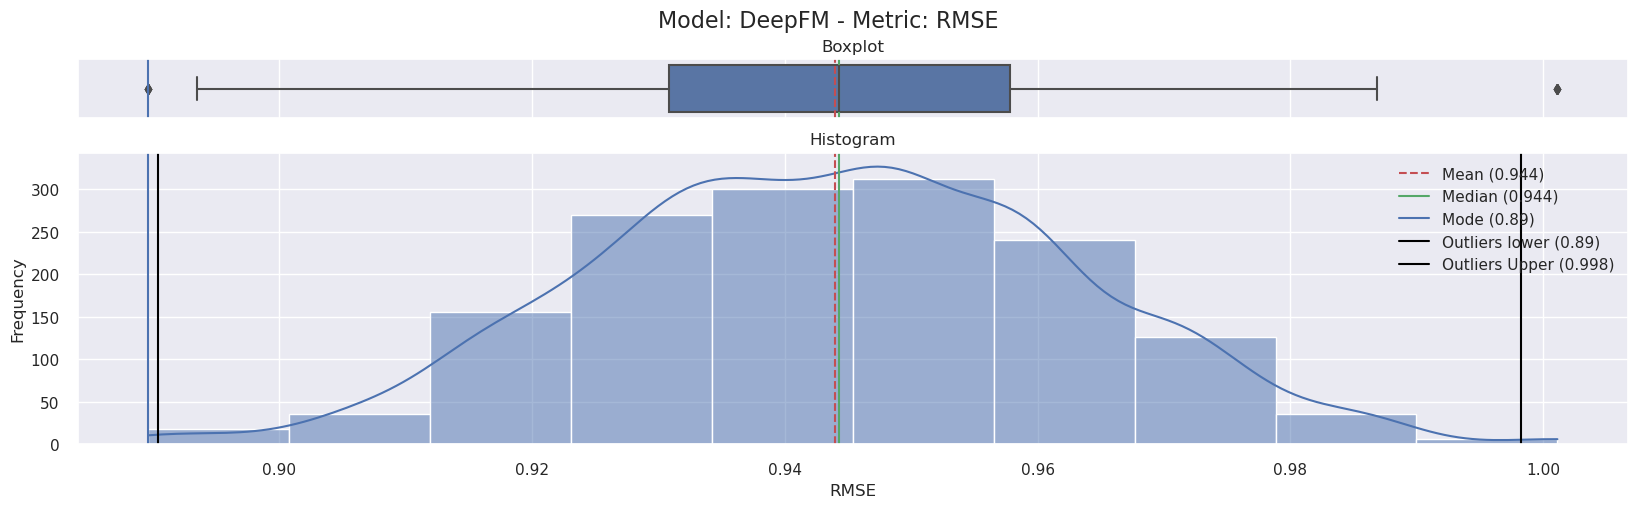

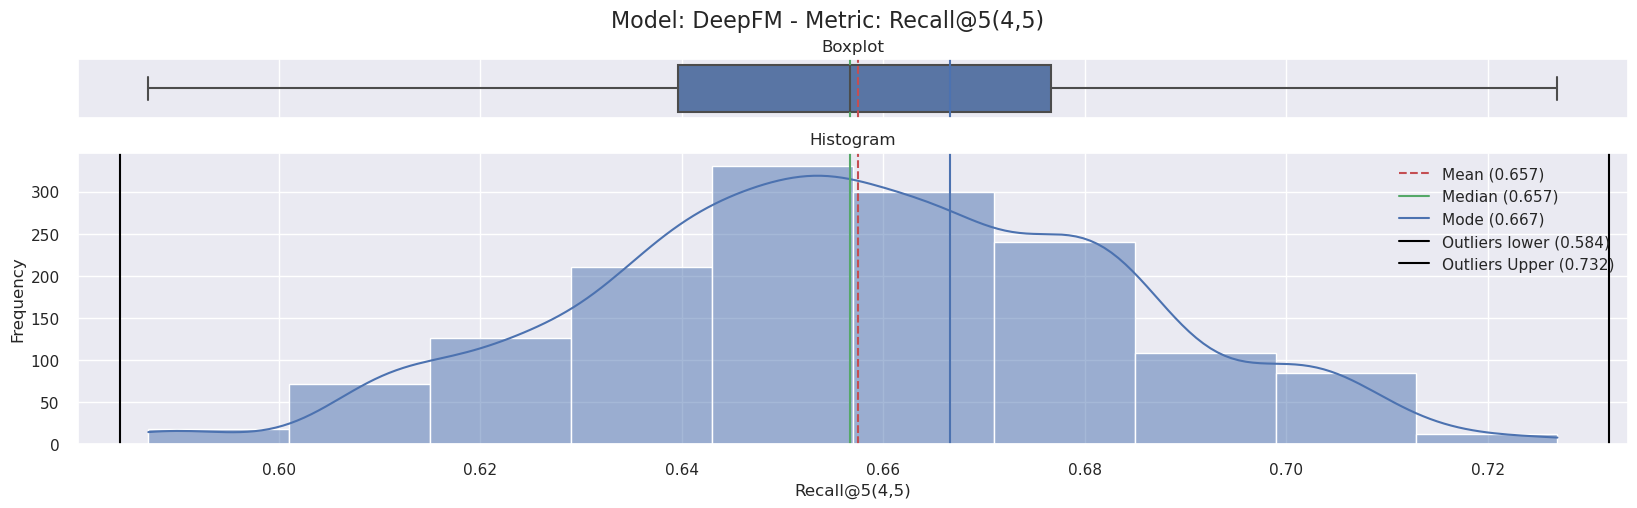

2024-01-31 21:15:25,591 - INFO - Get feature 0 embeddings [13017, 50]. Detail: Embeddings from 0 to 13016 from weights [31625, 50]
2024-01-31 21:15:25,591 - INFO - Get feature 1 embeddings [18608, 50]. Detail: Embeddings from 13017 to 31624 from weights [31625, 50]


Insert Embeddings:   0%|          | 0/11738 [00:00<?, ?it/s]

Insert Embeddings:   0%|          | 0/16752 [00:00<?, ?it/s]

In [10]:
user_embs, item_embs = AppContext().cf_emb_update_job()

## Simple item embeddings evaluation

In [11]:
from jobs import load_raw_dataset

ds = load_raw_dataset(path=os.environ['DATASET_PATH'])

In [14]:
if item_embs:
    result = AppContext().items_cf_emb_repository.search_sims(
        embs  = [item_embs[14033].emb],
        limit = 3
    )
    ds.data[ds.data['movie_id'].isin([item_embs[0].id] + result.ids)][['movie_title', 'movie_genres']].drop_duplicates(subset=['movie_title'])